# Shapley value analysis for Chemprop models

This notebook demonstrates how to perform Shapley (SHAP) value analysis for a chemprop model. In addition, it also serves as an example on how to customize chemprop featurizers.

* Example 1: Shapley value analysis to explain importance of default chemprop atom and bond features
* Example 2: Shapley value analysis to explain importance of particular atom/node and bond/edge
* Example 3: Shapley value analysis to explain importance of extra features (not yet implemented, will be done in the future release, this is likely eaiser to be achieved by modifying MoleculeDatapoint and dataloader functions)

Disclaimer: This notebook is for feature demonstration purposes only. The models used in this notebook are not trained models, and the computed Shapley values are provided solely for illustrative purposes. 

Note: This notebook is developed for Chemprop v2. 

For Chemprop v1 SHAP implementation checkout: https://github.com/oscarwumit/chemprop_developing/tree/shap_v1

This notebook requires the SHAP package, do "pip install shap" if you don't have it installed.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/chemprop/chemprop/blob/main/examples/shapley_value_with_customized_featurizers.ipynb)

In [ ]:
# Install chemprop from GitHub if running in Google Colab
import os

if os.getenv("COLAB_RELEASE_TAG"):
    try:
        import chemprop
    except ImportError:
        !git clone https://github.com/chemprop/chemprop.git
        %cd chemprop
        !pip install .
        !pip install shap
        %cd examples

### Citation for SHAP implementation in Chemprop

Li & Wu, et al. “When Do Quantum Mechanical Descriptors Help Graph Neural Networks to Predict Chemical Properties?” Journal of the American Chemical Society, vol. 146, no. 33, Aug. 2024, pp. 23103–20. https://doi.org/10.1021/jacs.4c04670.

Bibtex format
<pre>
@article{li_and_wu_qm_des_2024, 
	title = {When {Do} {Quantum} {Mechanical} {Descriptors} {Help} {Graph} {Neural} {Networks} to {Predict} {Chemical} {Properties}?}, 
	volume = {146}, 
	copyright = {https://doi.org/10.15223/policy-029}, 
	issn = {0002-7863, 1520-5126}, 
	url = {https://pubs.acs.org/doi/10.1021/jacs.4c04670}, 
	doi = {10.1021/jacs.4c04670}, 
	language = {en}, 
	number = {33}, 
	urldate = {2025-01-13}, 
	journal = {Journal of the American Chemical Society}, 
	author = {Li, Shih-Cheng and Wu, Haoyang and Menon, Angiras and Spiekermann, Kevin A. and Li, Yi-Pei and Green, William H.}, 
	month = aug, 
	year = {2024}, 
	pages = {23103--23120}, 
} 
</pre>

### Customize Chemprop featurizers for SHAP analysis

In [1]:
# Import dependencies and classes
import sys

from copy import deepcopy
from lightning import pytorch as pl
from pathlib import Path

import pandas as pd
import numpy as np
import torch

from dataclasses import InitVar, dataclass
from typing import List, Sequence, Tuple, Union, Optional
from rdkit import Chem
from rdkit.Chem import Mol, Draw
from rdkit.Chem.rdchem import Atom, Bond, BondType

from chemprop.featurizers.atom import MultiHotAtomFeaturizer 
from chemprop.featurizers.bond import MultiHotBondFeaturizer 
from chemprop.featurizers.molgraph.molecule import SimpleMoleculeMolGraphFeaturizer 

from chemprop.data.molgraph import MolGraph 
from chemprop.featurizers.base import GraphFeaturizer 
from chemprop.featurizers.molgraph.mixins import _MolGraphFeaturizerMixin 

from chemprop import data, featurizers, models 

import shap # do "pip install shap" if you don't have it installed

import logging

# Set logging level to WARNING to suppress INFO logs
logging.getLogger("lightning.pytorch.utilities.rank_zero").setLevel(logging.WARNING)

#### CustomMultiHotAtomFeaturizer

In [2]:
class CustomMultiHotAtomFeaturizer(MultiHotAtomFeaturizer):
    """A custom MultiHotAtomFeaturizer that allows for selective feature ablation.
        
    Parameters
    ----------
    keep_features : List[bool], optional
        a list of booleans to indicate which atom features to keep. If None, all features are kept. For any element that is False, the corresponding feature's encoding is set to all zeros. Useful for ablation and SHAP analysis.
    """
    
    def __init__(self,
                 atomic_nums: Sequence[int],
                 degrees: Sequence[int],
                 formal_charges: Sequence[int],
                 chiral_tags: Sequence[int],
                 num_Hs: Sequence[int],
                 hybridizations: Sequence[int],
                 keep_features: List[bool] = None):
        super().__init__(atomic_nums, degrees, formal_charges, chiral_tags, num_Hs, hybridizations)
        
        if keep_features is None:
            keep_features = [True] * (len(self._subfeats) + 2)
        self.keep_features = keep_features

    def __call__(self, a: Atom | None) -> np.ndarray:
        x = np.zeros(self._MultiHotAtomFeaturizer__size)
        if a is None:
            return x
        
        feats = [
            a.GetAtomicNum(),
            a.GetTotalDegree(),
            a.GetFormalCharge(),
            int(a.GetChiralTag()),
            int(a.GetTotalNumHs()),
            a.GetHybridization(),
        ]
        
        i = 0
        for feat, choices, keep in zip(feats, self._subfeats, self.keep_features[:len(feats)]):
            j = choices.get(feat, len(choices))
            if keep:
                x[i + j] = 1
            i += len(choices) + 1
        
        if self.keep_features[len(feats)]:
            x[i] = int(a.GetIsAromatic())
        if self.keep_features[len(feats) + 1]:
            x[i + 1] = 0.01 * a.GetMass()

        return x

    def zero_mask(self) -> np.ndarray:
        """Featurize the atom by setting all bits to zero."""
        return np.zeros(len(self))

In [ ]:
# Example usage
atomic_nums = [6, 7, 8]
degrees = [1, 2, 3]
formal_charges = [-1, 0, 1]
chiral_tags = [0, 1, 2]
num_Hs = [0, 1, 2]
hybridizations = [1, 2, 3]

keep_features_all = [True] * 8
keep_features_some = [True, True, False, True, False, True, True, False]
keep_features_none = [False] * 8

featurizer_all = CustomMultiHotAtomFeaturizer(
    atomic_nums=atomic_nums,
    degrees=degrees,
    formal_charges=formal_charges,
    chiral_tags=chiral_tags,
    num_Hs=num_Hs,
    hybridizations=hybridizations,
    keep_features=keep_features_all
)

featurizer_some = CustomMultiHotAtomFeaturizer(
    atomic_nums=atomic_nums,
    degrees=degrees,
    formal_charges=formal_charges,
    chiral_tags=chiral_tags,
    num_Hs=num_Hs,
    hybridizations=hybridizations,
    keep_features=keep_features_some
)

featurizer_none = CustomMultiHotAtomFeaturizer(
    atomic_nums=atomic_nums,
    degrees=degrees,
    formal_charges=formal_charges,
    chiral_tags=chiral_tags,
    num_Hs=num_Hs,
    hybridizations=hybridizations,
    keep_features=keep_features_none
)

mol = Chem.MolFromSmiles('CCO')
atom = mol.GetAtomWithIdx(0)  # Get the first atom

features = featurizer_all(atom)
print("Atom features all:", features)

features = featurizer_some(atom)
print("Atom features some:", features)

features = featurizer_none(atom)
print("Atom features none:", features)

Atom features all: [1.      0.      0.      0.      0.      0.      0.      1.      0.
 1.      0.      0.      1.      0.      0.      0.      0.      0.
 0.      1.      0.      0.      0.      1.      0.      0.12011]
Atom features some: [1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0.]
Atom features none: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]


#### CustomMultiHotBondFeaturizer

In [4]:
class CustomMultiHotBondFeaturizer(MultiHotBondFeaturizer):
    """A custom MultiHotBondFeaturizer that allows for selective feature ablation.
    
    Parameters
    ----------
    keep_features : List[bool], optional
        a list of booleans to indicate which bond features to keep except for nullity. If None, all features are kept. For any element that is False, the corresponding feature's encoding is set to all zeros. Useful for ablation and SHAP analysis.
    """
    
    def __init__(self,
                 bond_types: Sequence[BondType] | None = None,
                 stereos: Sequence[int] | None = None,
                 keep_features: List[bool] = None):
        super().__init__(bond_types, stereos)
        
        self._MultiHotBondFeaturizer__size = 1 + len(self.bond_types) + 2 + (len(self.stereo) + 1)

        if keep_features is None:
            keep_features = [True] * 4 
        self.keep_features = keep_features        

    def __len__(self) -> int:
        return self._MultiHotBondFeaturizer__size

    def __call__(self, b: Bond) -> np.ndarray:
        x = np.zeros(len(self), int)

        if b is None:
            x[0] = 1
            return x
        i = 1
        bond_type = b.GetBondType()
        bt_bit, size = self.one_hot_index(bond_type, self.bond_types)
        if self.keep_features[0] and bt_bit != size:
            x[i + bt_bit] = 1
        i += size - 1

        if self.keep_features[1]:
            x[i] = int(b.GetIsConjugated())
        if self.keep_features[2]:
            x[i + 1] = int(b.IsInRing())
        i += 2

        if self.keep_features[3]:
            stereo_bit, _ = self.one_hot_index(int(b.GetStereo()), self.stereo)
            x[i + stereo_bit] = 1

        return x

    def zero_mask(self) -> np.ndarray:
        """Featurize the bond by setting all bits to zero."""
        return np.zeros(len(self), int)

    @classmethod
    def one_hot_index(cls, x, xs: Sequence) -> tuple[int, int]:
        """Returns a tuple of the index of ``x`` in ``xs`` and ``len(xs) + 1`` if ``x`` is in ``xs``.
        Otherwise, returns a tuple with ``len(xs)`` and ``len(xs) + 1``."""
        n = len(xs)
        return xs.index(x) if x in xs else n, n + 1

In [5]:
# Example usage
bond_types = [BondType.SINGLE, BondType.DOUBLE, BondType.TRIPLE, BondType.AROMATIC]
stereos = [0, 1, 2, 3, 4, 5]
keep_features_all = [True] * 4
keep_features_some = [True, False, True, False]
keep_features_none = [False] * 4

featurizer_all = CustomMultiHotBondFeaturizer(
    bond_types=bond_types,
    stereos=stereos,
    keep_features=keep_features_all
)

featurizer_some = CustomMultiHotBondFeaturizer(
    bond_types=bond_types,
    stereos=stereos,
    keep_features=keep_features_some
)

featurizer_none = CustomMultiHotBondFeaturizer(
    bond_types=bond_types,
    stereos=stereos,
    keep_features=keep_features_none
)

mol = Chem.MolFromSmiles('CCO')
bond = mol.GetBondWithIdx(0)  # Get the first bond

features = featurizer_all(bond)
print("Bond features all:", features)

features = featurizer_some(bond)
print("Bond features some:", features)

features = featurizer_none(bond)
print("Bond features none:", features)

Bond features all: [0 1 0 0 0 0 0 1 0 0 0 0 0 0]
Bond features some: [0 1 0 0 0 0 0 0 0 0 0 0 0 0]
Bond features none: [0 0 0 0 0 0 0 0 0 0 0 0 0 0]


#### CustomSimpleMoleculeMolGraphFeaturizer

In [6]:
@dataclass
class CustomSimpleMoleculeMolGraphFeaturizer(SimpleMoleculeMolGraphFeaturizer):
    """A custom SimpleMoleculeMolGraphFeaturizer with additional feature control."""
    
    keep_atom_features: Optional[List[bool]] = None
    keep_bond_features: Optional[List[bool]] = None
    keep_atoms: Optional[List[bool]] = None
    keep_bonds: Optional[List[bool]] = None

    def __post_init__(self, extra_atom_fdim: int = 0, extra_bond_fdim: int = 0):
        super().__post_init__(extra_atom_fdim, extra_bond_fdim)

        if isinstance(self.atom_featurizer, CustomMultiHotAtomFeaturizer) and self.keep_atom_features is not None:
            self.atom_featurizer.keep_features = self.keep_atom_features
        if isinstance(self.bond_featurizer, CustomMultiHotBondFeaturizer) and self.keep_bond_features is not None:
            self.bond_featurizer.keep_features = self.keep_bond_features

    def __call__(
        self,
        mol: Chem.Mol,
        atom_features_extra: np.ndarray | None = None,
        bond_features_extra: np.ndarray | None = None,
    ) -> MolGraph:
        n_atoms = mol.GetNumAtoms()
        n_bonds = mol.GetNumBonds()

        if self.keep_atoms is None:
            self.keep_atoms = [True] * n_atoms
        if self.keep_bonds is None:
            self.keep_bonds = [True] * n_bonds

        if atom_features_extra is not None and len(atom_features_extra) != n_atoms:
            raise ValueError(
                "Input molecule must have same number of atoms as `len(atom_features_extra)`!"
                f"got: {n_atoms} and {len(atom_features_extra)}, respectively"
            )
        if bond_features_extra is not None and len(bond_features_extra) != n_bonds:
            raise ValueError(
                "Input molecule must have same number of bonds as `len(bond_features_extra)`!"
                f"got: {n_bonds} and {len(bond_features_extra)}, respectively"
            )
        if n_atoms == 0:
            V = np.zeros((1, self.atom_fdim), dtype=np.single)
        else:
            V = np.array([self.atom_featurizer(a) if self.keep_atoms[a.GetIdx()] else self.atom_featurizer.zero_mask()
                          for a in mol.GetAtoms()], dtype=np.single)

        if atom_features_extra is not None:
            V = np.hstack((V, atom_features_extra))

        E = np.empty((2 * n_bonds, self.bond_fdim))
        edge_index = [[], []]

        i = 0
        for u in range(n_atoms):
            for v in range(u + 1, n_atoms):
                bond = mol.GetBondBetweenAtoms(u, v)
                if bond is None:
                    continue

                x_e = self.bond_featurizer(bond) if self.keep_bonds[bond.GetIdx()] else self.bond_featurizer.zero_mask()

                if bond_features_extra is not None:
                    x_e = np.concatenate((x_e, bond_features_extra[bond.GetIdx()]), dtype=np.single)

                E[i: i + 2] = x_e
                edge_index[0].extend([u, v])
                edge_index[1].extend([v, u])
                i += 2

        rev_edge_index = np.arange(len(E)).reshape(-1, 2)[:, ::-1].ravel()
        edge_index = np.array(edge_index, int)
        return MolGraph(V, E, edge_index, rev_edge_index)

In [7]:
# Example usage
atom_featurizer = CustomMultiHotAtomFeaturizer(
    atomic_nums=[6, 7, 8],
    degrees=[1, 2, 3],
    formal_charges=[-1, 0, 1],
    chiral_tags=[0, 1, 2],
    num_Hs=[0, 1, 2],
    hybridizations=[1, 2, 3],
    keep_features=[True, True, False, True, False, True, True, False]
)

bond_featurizer = CustomMultiHotBondFeaturizer(
    bond_types=[BondType.SINGLE, BondType.DOUBLE, BondType.TRIPLE, BondType.AROMATIC],
    stereos=[0, 1, 2, 3, 4, 5],
    keep_features=[True, False, True, False]
)

featurizer = CustomSimpleMoleculeMolGraphFeaturizer(
    atom_featurizer=atom_featurizer,
    bond_featurizer=bond_featurizer,
    keep_atom_features=[True, True, False, True, False, True, True, False],
    keep_bond_features=[True, False, True, False],
)

# Example molecule (RDKit Mol object required)
from rdkit import Chem
mol = Chem.MolFromSmiles('CCO')

mol_graph = featurizer(mol)
print("Molecule graph:", mol_graph)

Molecule graph: MolGraph(V=array([[1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]], dtype=float32), E=array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]), edge_index=array([[0, 1, 1, 2],
       [1, 0, 2, 1]]), rev_edge_index=array([1, 0, 3, 2]))


### SHAP analysis to interpret Chemprop model prediction

### Example 1: Shapley value analysis to explain importance of default chemprop atom and bond features

In [8]:
chemprop_dir = Path.cwd().parent

# load chemprop model checkpoint file
checkpoint_path = chemprop_dir / "tests" / "data" / "example_model_v2_regression_mol.ckpt" 
mpnn = models.MPNN.load_from_checkpoint(checkpoint_path)

# load data
test_path = chemprop_dir / "tests" / "data" / "regression" / "mol" / "mol.csv"
smiles_column = 'smiles'
df_test = pd.read_csv(test_path)
smis = df_test[smiles_column]
test_data = [data.MoleculeDatapoint.from_smi(smi) for smi in smis]

# pick a test molecule for demonstration 
test_mol = smis.iloc[0]
print(f"Testing molecule: {test_mol}")

Testing molecule: Cn1c(CN2CCN(CC2)c3ccc(Cl)cc3)nc4ccccc14


In [9]:
# initialize the featurizer
atom_featurizer = CustomMultiHotAtomFeaturizer.v2() # chemprop v2 default atom featurizer settings
bond_featurizer = CustomMultiHotBondFeaturizer()

In [10]:
# A helper function to get predictions from a molecule with ability to keep or remove specific atom and bond features
def get_predictions(keep_atom_features: Optional[List[bool]], keep_bond_features: Optional[List[bool]], mol: str) -> float:
    featurizer = CustomSimpleMoleculeMolGraphFeaturizer(
        atom_featurizer=atom_featurizer,
        bond_featurizer=bond_featurizer,
        keep_atom_features=keep_atom_features,
        keep_bond_features=keep_bond_features
    )
    test_data = [data.MoleculeDatapoint.from_smi(mol)]
    test_dset = data.MoleculeDataset(test_data, featurizer=featurizer)
    test_loader = data.build_dataloader(test_dset, shuffle=False, batch_size=1)

    with torch.inference_mode():
        trainer = pl.Trainer(
            logger=False,
            enable_progress_bar=False,
            accelerator="cpu",
            devices=1
        )
        test_preds = trainer.predict(mpnn, test_loader)
    return test_preds[0][0]

In [11]:
# example prediction with different keep_atom_features and keep_bond_features

# keep all atom and bond features
keep_atom_features_0 = [True]*8
keep_bond_features_0 = [True]*4

# keep some atom and bond features
keep_atom_features_1 = [True, True, False, True, True, False, True, True]
keep_bond_features_1 = [True, True, False, True]

# remove all atom and bond features
keep_atom_features_2 = [False]*8
keep_bond_features_2 = [False]*4

pred_0 = get_predictions(keep_atom_features_0, keep_bond_features_0, test_mol)
pred_1 = get_predictions(keep_atom_features_1, keep_bond_features_1, test_mol)
pred_2 = get_predictions(keep_atom_features_2, keep_bond_features_2, test_mol)

print(f"Prediction with keep_features set 0: {pred_0}") # expected 2.2535
print(f"Prediction with keep_features set 1: {pred_1}") # expected 2.2319
print(f"Prediction with keep_features set 2: {pred_2}") # expected 2.1880

/home/knathan/anaconda3/envs/chemprop_delete/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Prediction with keep_features set 0: tensor([2.2535])
Prediction with keep_features set 1: tensor([2.2319])
Prediction with keep_features set 2: tensor([2.1880])


In [12]:
# An example wrapper class for use as the model input in SHAP explainer
# The wrapper needs to be initialized first with the molecule to be explained, and then can be called with a boolean list representing the features to keep
# The wrapper is needed because SHAP explainer requires a callable model with a single input argument, adapt X as needed
class MoleculeModelWrapper:
    def __init__(self, mol: str):
        self.mol = mol
    
    def __call__(self, X):
        preds = []
        for keep_features in X:
            try:
                # unpacking X, indices corresponds to feature orders from default chemprop featurizer, adapt as needed
                keep_atom_features = keep_features[:8] # 8 atom features
                keep_bond_features = keep_features[8:] # 4 bond features
            except:
                print(f"Invalid input: {keep_features}")
                raise
            pred = get_predictions(keep_atom_features, keep_bond_features, self.mol)
            preds.append([pred.item()])
        return np.array(preds)

In [13]:
# An example masker function for use with SHAP explainer
# The masker function takes in a binary mask and the input data X, and returns the masked input data. This simulates the effect of masking out certain features.
def binary_masker(binary_mask, x):
    masked_x = deepcopy(x)
    masked_x[binary_mask == 0] = 0
    return np.array([masked_x])

In [14]:
# Initialize the model wrapper with the test molecule
model_wrapper = MoleculeModelWrapper(test_mol)

In [15]:
# Test the model wrapper with a random feature choice
keep_features = [1] * 12  # 8 atom features + 4 bond features
feature_choice = np.array([keep_features])
model_wrapper(feature_choice) # expected 2.25354171

array([[2.25354147]])

In [16]:
# Initialize the SHAP explainer with the model wrapper and masker
explainer = shap.PermutationExplainer(model_wrapper, masker=binary_masker)

In [17]:
# Compute SHAP values, using 100 evaluations of different feature choices (notice that feature choices are masked out randomly by the binary masker, so the results may vary between runs)
explanation = explainer(feature_choice, max_evals=100) 

/home/knathan/anaconda3/envs/chemprop_delete/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
PermutationExplainer explainer: 2it [00:28, 28.55s/it]               


In [18]:
# Print the SHAP values
explanation

.values =
array([[ 0.00123063,  0.01496077,  0.00213072, -0.01216608,  0.00954816,
         0.00413817,  0.00643879, -0.00101143,  0.01162252,  0.00842983,
         0.00846943,  0.01178101]])

.base_values =
array([[2.18796897]])

.data =
array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

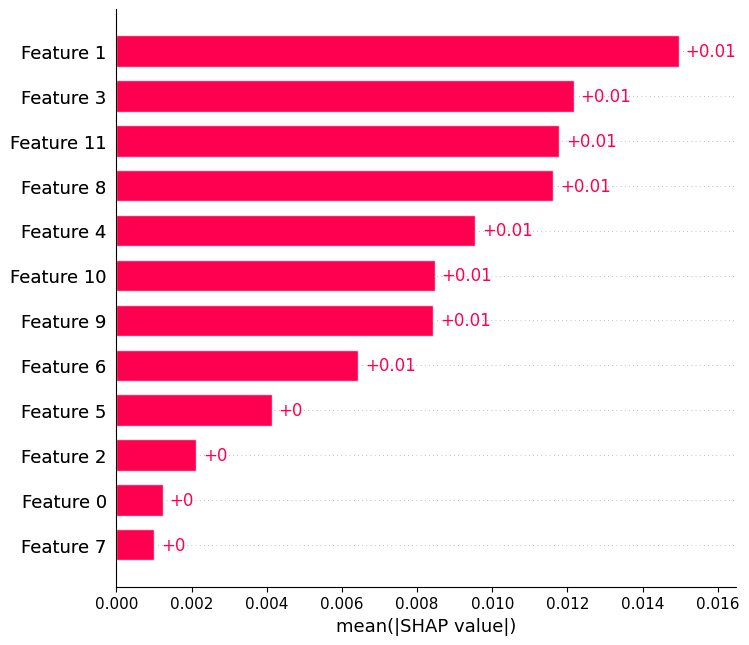

In [19]:
# Plot the SHAP values
shap.plots.bar(explanation, max_display=15)

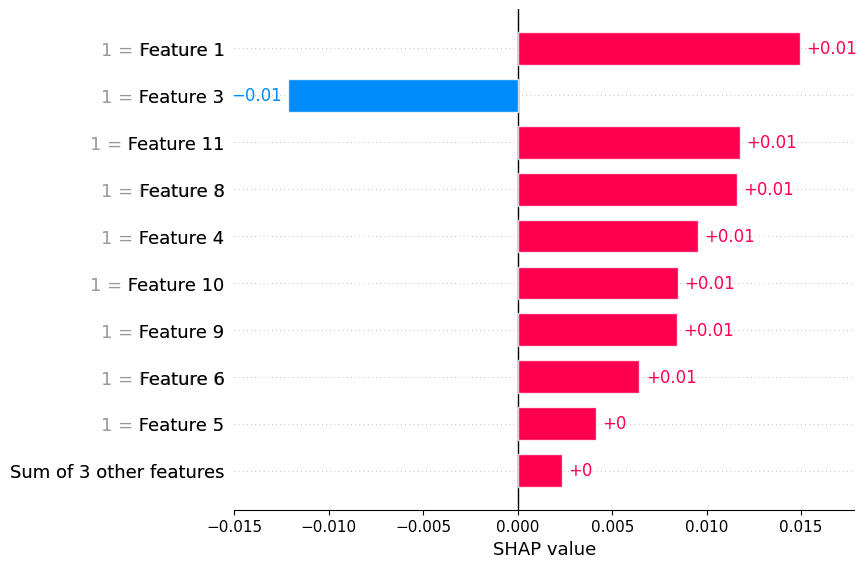

In [20]:
# Plot the SHAP values
shap.plots.bar(explanation[0])

### Example 2: Shapley value analysis to explain importance of particular atom/node and bond/edge

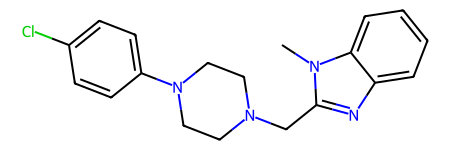

In [21]:
mol = Chem.MolFromSmiles(test_mol)
mol

In [22]:
n_atoms = mol.GetNumAtoms()
n_bonds = mol.GetNumBonds()
print(f"Number of atoms: {n_atoms}, Number of bonds: {n_bonds}")

Number of atoms: 24, Number of bonds: 27


In [23]:
# initialize the featurizer
atom_featurizer = CustomMultiHotAtomFeaturizer.v2() # chemprop v2 default atom featurizer settings
bond_featurizer = CustomMultiHotBondFeaturizer()

In [24]:
# A helper function to get predictions from a molecule with ability to keep or remove specific atom/node or bond/edge
def get_predictions(keep_atoms: Optional[List[bool]], keep_bonds: Optional[List[bool]], mol: str) -> float:
    featurizer = CustomSimpleMoleculeMolGraphFeaturizer(
        atom_featurizer=atom_featurizer,
        bond_featurizer=bond_featurizer,
        keep_atoms=keep_atoms,
        keep_bonds=keep_bonds
    )
    test_data = [data.MoleculeDatapoint.from_smi(mol)]
    test_dset = data.MoleculeDataset(test_data, featurizer=featurizer)
    test_loader = data.build_dataloader(test_dset, shuffle=False, batch_size=1)

    with torch.inference_mode():
        trainer = pl.Trainer(
            logger=False,
            enable_progress_bar=False,
            accelerator="cpu",
            devices=1
        )
        test_preds = trainer.predict(mpnn, test_loader)
    return test_preds[0][0]

In [25]:
# example prediction with different keep_atoms and keep_bonds

# keep all atoms and bonds
keep_atoms_0 = [True] * n_atoms
keep_bonds_0 = [True] * n_bonds

# remove all atoms and bonds
keep_atoms_1 = [False] * n_atoms
keep_bonds_1 = [False] * n_bonds

pred_0 = get_predictions(keep_atoms_0, keep_bonds_0, test_mol)
pred_1 = get_predictions(keep_atoms_1, keep_bonds_1, test_mol)

print(f"Prediction with all atoms and bonds kept: {pred_0}") # expected 2.2535
print(f"Prediction with all atoms and bonds removed: {pred_1}") # expected 2.1880

/home/knathan/anaconda3/envs/chemprop_delete/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Prediction with all atoms and bonds kept: tensor([2.2535])
Prediction with all atoms and bonds removed: tensor([2.1880])


In [26]:
# An example wrapper class for use as the model input in SHAP explainer
class MoleculeModelWrapper:
    def __init__(self, mol: str, n_atoms: int, n_bonds: int):
        self.mol = mol
        self.n_atoms = n_atoms
        self.n_bonds = n_bonds
    def __call__(self, X):
        preds = []
        for keep_features in X:
            try:
                # unpacking X, indices corresponds to atom.GetIdx() and bond.GetIdx() from rdkit mol, adapt as needed
                keep_atoms = keep_features[:self.n_atoms]
                keep_bonds = keep_features[self.n_atoms:self.n_atoms + self.n_bonds]
            except Exception as e:
                print(f"Invalid input: {keep_features}")
                raise e
            pred = get_predictions(keep_atoms, keep_bonds, self.mol)
            preds.append([pred.item()])
        return np.array(preds)

In [27]:
# An example masker function for use with SHAP explainer
# The masker function takes in a binary mask and the input data X, and returns the masked input data. This simulates the effect of masking out certain features.
def binary_masker(binary_mask, x):
    masked_x = deepcopy(x)
    masked_x[binary_mask == 0] = 0
    return np.array([masked_x])

In [28]:
# Initialize the model wrapper with the test molecule, number of atoms and bonds
model_wrapper = MoleculeModelWrapper(test_mol, n_atoms, n_bonds)

In [29]:
# Test the model wrapper with a random node/edge choice
keep_features = [1] * (n_atoms + n_bonds)
feature_choice = np.array([keep_features])
model_wrapper(feature_choice)

array([[2.25354147]])

In [30]:
# Initialize the SHAP explainer with the model wrapper and masker
explainer = shap.PermutationExplainer(model_wrapper, masker=binary_masker)

In [31]:
# Compute SHAP values, using 200 evaluations of different node/edge choices (notice that nodes and edges are masked out randomly by the binary masker, so the results may vary between runs)
explanation = explainer(feature_choice, max_evals=200)

PermutationExplainer explainer: 2it [00:25, 25.79s/it]               


In [32]:
# Print the SHAP values
explanation

.values =
array([[-6.33835793e-04,  2.00152397e-04,  8.77737999e-04,
        -1.20162964e-04, -1.70385838e-03,  1.32679939e-04,
         5.65052032e-04, -1.49548054e-03,  1.45280361e-03,
         7.84397125e-05,  7.94768333e-04,  1.32918358e-03,
         1.59931183e-03,  7.92026520e-04, -1.05524063e-03,
         1.27375126e-03,  1.26934052e-03, -5.46216965e-04,
         2.07734108e-03,  9.27805901e-04,  1.94215775e-03,
         1.70767307e-03,  9.18865204e-04,  2.30920315e-03,
         1.02865696e-03,  2.66933441e-03,  3.65734100e-04,
         1.01172924e-03,  1.39999390e-03,  1.10065937e-03,
         1.54471397e-03,  1.68943405e-03,  1.58667564e-03,
         8.28027725e-04,  2.80642509e-03,  2.18117237e-03,
         2.17568874e-03,  9.46164131e-04,  1.96087360e-03,
         2.82001495e-03,  2.58827209e-03,  2.84719467e-03,
         2.18105316e-03,  2.61569023e-03,  1.97517872e-03,
         2.07221508e-03,  2.10452080e-03,  1.83522701e-03,
         1.78325176e-03,  2.54166126e-03,  2.2

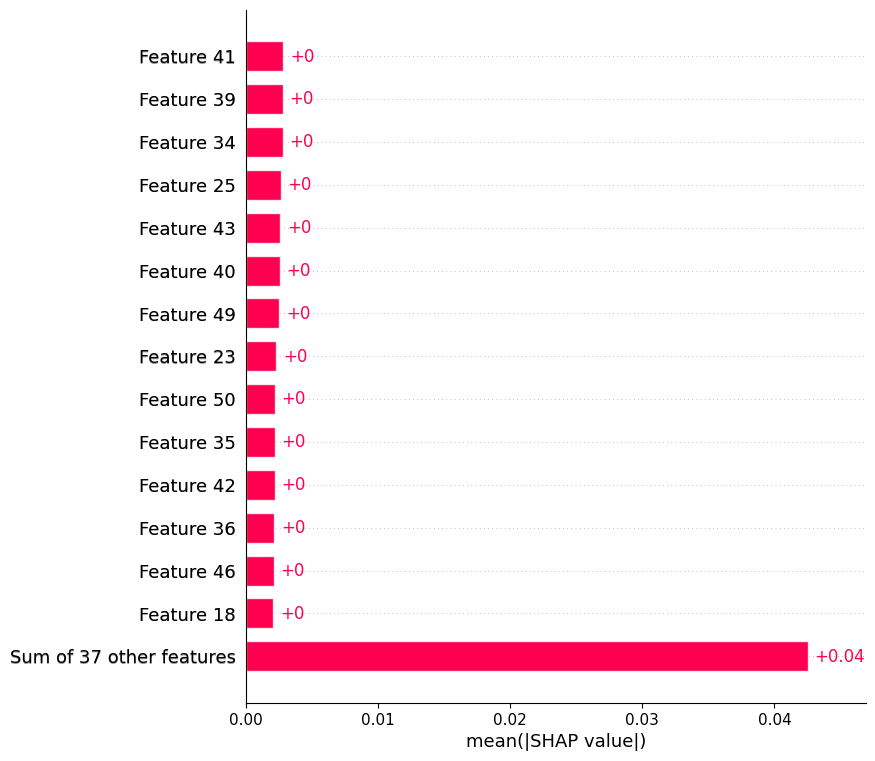

In [33]:
# Plot the SHAP values, notice that "feature 0" corresponds to the first atom, "feature 1" corresponds to the second atom, and so on also for bonds
shap.plots.bar(explanation, max_display=15)

In [34]:
# Get the SHAP values for atoms and bonds
shap_values = explanation.values[0]
atom_shap_values = shap_values[:n_atoms]
bond_shap_values = shap_values[n_atoms:n_atoms + n_bonds]

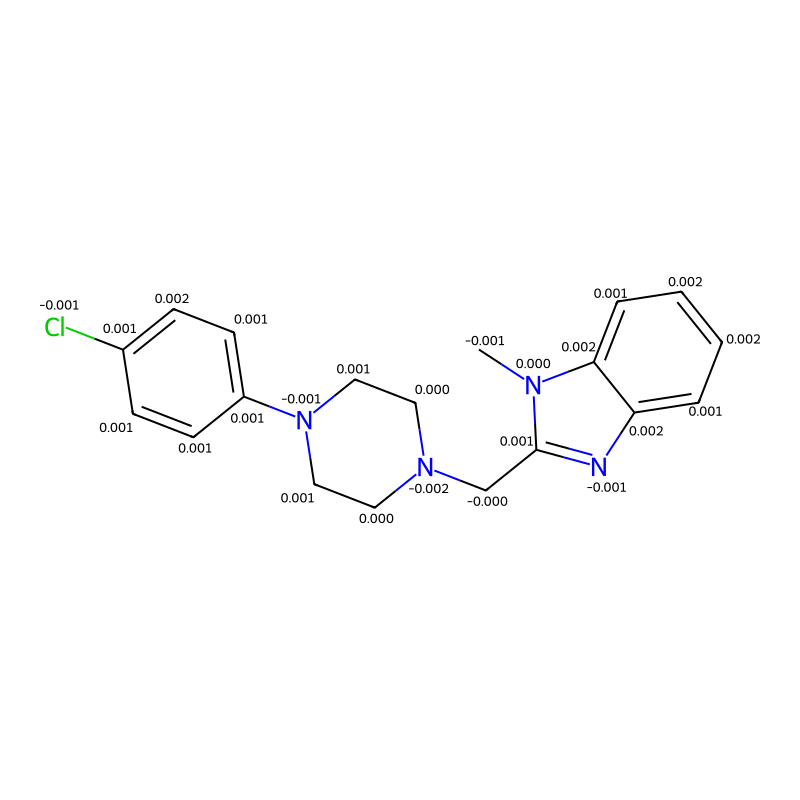

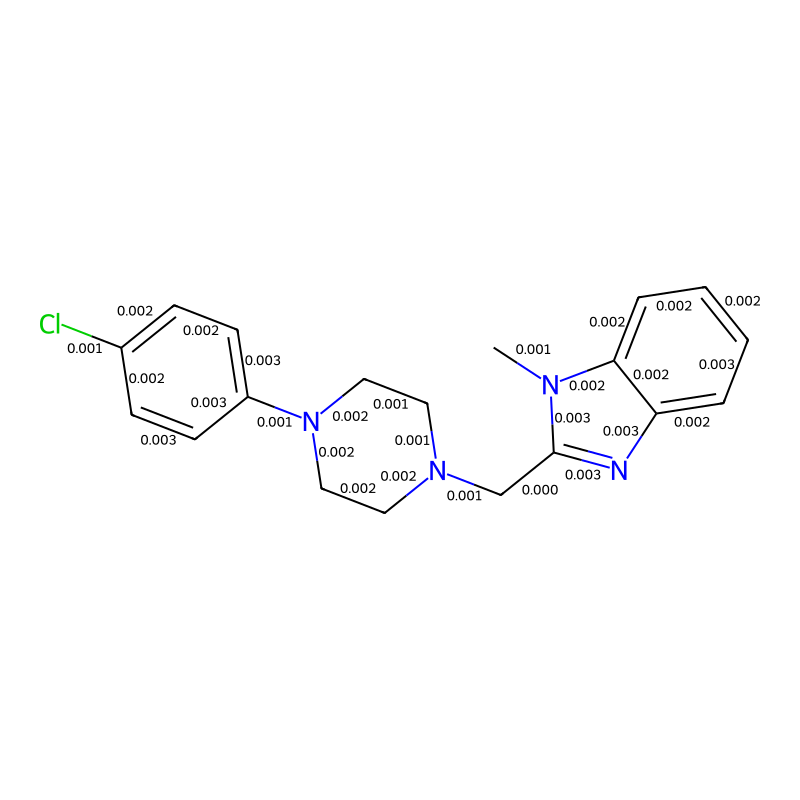

In [35]:
# Draw molecule with atom SHAP values
atom_labels = {i: f'{atom_shap_values[i]:.3f}' for i in range(n_atoms) if atom_shap_values[i] != 0}
mol_with_atom_shap = Chem.Mol(mol)
for atom in mol_with_atom_shap.GetAtoms():
    atom_idx = atom.GetIdx()
    if atom_idx in atom_labels:
        atom.SetProp('atomNote', atom_labels[atom_idx])
img_atom_shap = Draw.MolToImage(mol_with_atom_shap, size=(800, 800), kekulize=True)
img_atom_shap.save('atom_shap_values.png')

# Draw molecule with bond SHAP values
bond_labels = {bond.GetIdx(): f'{bond_shap_values[bond.GetIdx()]:.3f}' for bond in mol.GetBonds() if bond_shap_values[bond.GetIdx()] != 0}
mol_with_bond_shap = Chem.Mol(mol)
for bond in mol_with_bond_shap.GetBonds():
    bond_idx = bond.GetIdx()
    if bond_idx in bond_labels:
        bond.SetProp('bondNote', bond_labels[bond_idx])
img_bond_shap = Draw.MolToImage(mol_with_bond_shap, size=(800, 800), kekulize=True)
img_bond_shap.save('bond_shap_values.png')

# Display the images if running in a Jupyter notebook
try:
    from IPython.display import Image, display
    display(Image(filename='atom_shap_values.png'))
    display(Image(filename='bond_shap_values.png'))
except ImportError:
    print("IPython is not installed. Images are saved as 'atom_shap_values.png' and 'bond_shap_values.png'.")